### 🧠 What is Self-Reflection in RAG?
Self-reflection = LLM evaluates its own output:
“Is this clear, complete, and accurate?”

#### Self-Reflection in RAG using LangGraph, we’ll design a workflow where the agent:

1. Generates an initial answer using retrieved context
2. Reflects on that answer with a dedicated self-critic LLM step
3. If unsatisfied, it can revise the query, retrieve again, or regenerate the answer

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END
from langchain_huggingface import HuggingFaceEmbeddings

d:\RAG\AgenticAI-LangGraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()

llm=init_chat_model("groq:openai/gpt-oss-20b")

In [3]:
docs = TextLoader("research_notes.txt").load()
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
vectorstore = FAISS.from_documents(chunks, HuggingFaceEmbeddings())
retriever = vectorstore.as_retriever()

In [4]:
# -------------------------
# 2. State Definition
# -------------------------
class RAGReflectionState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""
    reflection: str = ""
    revised: bool = False
    attempts: int = 0

In [12]:
# -------------------------
# 3. Nodes
# -------------------------

# a. Retrieve
def retrieve_docs(state: RAGReflectionState) -> RAGReflectionState:
    docs = retriever.invoke(state.question)
    return state.model_copy(update={"retrieved_docs": docs})

# b. Generate Answer
def generate_answer(state: RAGReflectionState) -> RAGReflectionState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
Use the following context to answer the question. Do not include information outside the context in your answer:

Context:
{context}

Question:
{state.question}
"""
    answer = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": answer, "attempts": state.attempts + 1})

In [13]:
# c. Self-Reflect
def reflect_on_answer(state: RAGReflectionState) -> RAGReflectionState:
    
    prompt = f"""
Reflect on the following answer to see if it fully addresses the question. 
State YES if it is complete and correct, or NO with an explanation.

Question: {state.question}

Answer: {state.answer}

Respond like:
Reflection: YES or NO
Explanation: ...
"""
    result = llm.invoke(prompt).content
    is_ok = "reflection: yes" in result.lower()
    return state.model_copy(update={"reflection": result, "revised": not is_ok})

In [14]:
# d. Finalizer
def finalize(state: RAGReflectionState) -> RAGReflectionState:
    return state

In [15]:
# -------------------------
# 4. LangGraph DAG
# -------------------------
builder = StateGraph(RAGReflectionState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)
builder.add_node("reflector", reflect_on_answer)
builder.add_node("done", finalize)

builder.set_entry_point("retriever")

builder.add_edge("retriever", "responder")
builder.add_edge("responder", "reflector")
builder.add_conditional_edges(
    "reflector",
    lambda s: "done" if not s.revised or s.attempts >= 2 else "retriever"
)

builder.add_edge("done", END)
graph = builder.compile()

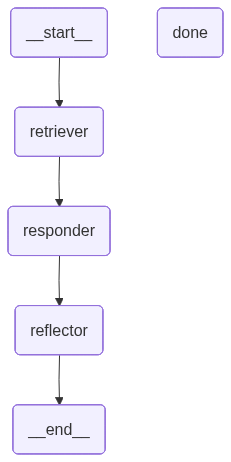

In [16]:
graph

In [18]:
# -------------------------
# 5. Run the Agent
# -------------------------
if __name__ == "__main__":
    user_query = "What are the transformer variants in production deployments?"
    init_state = RAGReflectionState(question=user_query)
    result = graph.invoke(init_state)

    print("\n🧠 Final Answer:\n", result["answer"])
    print("\n🔁 Reflection Log:\n", result["reflection"])
    print("🔄 Total Attempts:", result["attempts"])


🧠 Final Answer:
 In production systems the most common transformer architectures are the three canonical variants:

| Variant | Typical use in production | Example models |
|---------|--------------------------|----------------|
| **Decoder‑only** | Autoregressive language generation, chat, code completion, and any task that needs to predict the next token | GPT‑3, GPT‑4, GPT‑Neo, GPT‑J |
| **Encoder‑only** | Representation‑based tasks such as classification, question‑answering, and feature extraction | BERT, RoBERTa, ALBERT, ELECTRA |
| **Encoder‑decoder** | Sequence‑to‑sequence mapping such as translation, summarization, or any task that requires an input sequence to be transformed into an output sequence | T5, BART, mT5, PEGASUS |

These three families cover the bulk of production deployments, with the decoder‑only models used for generative workloads, encoder‑only models for understanding/analysis workloads, and encoder‑decoder models for translation, summarization, or any other s